In [4]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [5]:
dataset_path = 'dataset/'
preprocessed_dataset_path = "preprocessed_dataset/"

In [6]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

In [179]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df.csv')
mixed_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/mixed_volumetric_df.csv')


In [147]:
dHCP_outcomes = pd.read_csv(f'../../dataset/participant_outcome/DHCPNDH1-LeHaiOutcome_DATA_LABELS_2022-06-09_0947.csv')
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes.iloc[:,np.r_[0,4,11:13,13,16:19,21:24,34,56,72,77:92]].copy()
dHCP_outcomes_CBCL_Bayley.rename(columns={'IMD Score':'IMD'},inplace=True)
dHCP_outcomes_CBCL_Bayley = dHCP_outcomes_CBCL_Bayley.dropna()

In [16]:
[(idx,i) for idx,i in enumerate(dHCP_outcomes.columns)]

[(0, 'Participant ID'),
 (1, 'Event Name'),
 (2, 'Repeat Instrument'),
 (3, 'Repeat Instance'),
 (4, 'IMD Score'),
 (5, 'IMD Quintile'),
 (6, "Child's Sex"),
 (7, 'Bayley First or Second?'),
 (8, 'Eye Tracking First or Second'),
 (9, 'Age - Months'),
 (10, 'Age - Days'),
 (11, 'Corrected Age - Months'),
 (12, 'Corrected Age - Days'),
 (13, 'Cognitive Scaled Score'),
 (14, 'Composite Score'),
 (15, 'Cognitive Rank'),
 (16, 'Receptive Communication Scaled Score'),
 (17, 'Expressive Communication Scaled Score'),
 (18, 'Sum Communication Scaled Scores'),
 (19, 'Communication Composite Score'),
 (20, 'Communication Rank'),
 (21, 'Fine Motor Scaled Score'),
 (22, 'Gross Motor Scaled Score'),
 (23, 'Sum Motor Scaled Scores'),
 (24, 'Motor Composite Score'),
 (25, 'Motor Rank'),
 (26, 'Cognition'),
 (27, 'Receptive Communication'),
 (28, 'Expressive Communication'),
 (29, 'Fine Motor'),
 (30, 'Gross Motor'),
 (31, 'Laxness'),
 (32, 'Over-reactivity'),
 (33, 'Verbosity'),
 (34, 'Parenting Style

In [148]:
dHCP_psychiatry = dHCP_outcomes.iloc[:,np.r_[0,40:51,62:70]].copy()

In [150]:
for col in dHCP_psychiatry.columns.tolist()[1:]:
    dHCP_psychiatry.loc[:,col] = [1 if i == 'Yes' else 0 if i=='No' else np.nan for i in dHCP_psychiatry.loc[:,col].values]

In [151]:
dHCP_psychiatry = dHCP_psychiatry.dropna().copy()

In [153]:
dHCP_psychiatry['family_history'] = [1 if i>0 else 0 for i in dHCP_psychiatry.iloc[:,1:].sum(axis=1).values]

In [154]:
dHCP_psychiatry = dHCP_psychiatry[['Participant ID','family_history']]

In [155]:
dHCP_psychiatry.columns = ['ID','family_history']

In [180]:
mixed_volumetric_dataset_term = data_preprocessing.Volumes.Group_Imperial_volumes(mixed_volumetric_dataset_term,grouping='segmented',remove_duplicated=True)
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]
mixed_volumetric_dataset_term = data_exploration.MassUnivariate.remove_outliers(mixed_volumetric_dataset_term,
                                                    col=['WM_sum_Imperial'],
                                                     threshold=3,
                                                    remove_schemes='sum',percentage_of_outlier=0.1)

In [181]:
mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(dHCP_psychiatry,on='ID',how='inner')

In [182]:
ancestry=[f'mixed_Anc_PC{i}' for i in range(1,6)]
data_exploration.MassUnivariate.mass_univariate(df=mixed_volumetric_dataset_term,
                                               cat_independentVar_cols=['Gender','family_history'],
                                               cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial']+ancestry,
                                               dependentVar_cols=['Imperial 79'])

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fed267cd5b0>,
                const_coef     const_pval  GA_vol_coef  GA_vol_pval  \
 Imperial 79  30456.152887  2.723682e-187    -1.609545     0.991423   
 
              PMA_vol_coef  PMA_vol_pval  Intracranial_Imperial_coef  \
 Imperial 79  -1850.596591  1.167299e-13                 4198.757831   
 
              Intracranial_Imperial_pval  mixed_Anc_PC1_coef  \
 Imperial 79                8.418905e-51           59.789742   
 
              mixed_Anc_PC1_pval  ...  mixed_Anc_PC3_coef  mixed_Anc_PC3_pval  \
 Imperial 79            0.626902  ...         -306.950068            0.020883   
 
              mixed_Anc_PC4_coef  mixed_Anc_PC4_pval  mixed_Anc_PC5_coef  \
 Imperial 79           56.207192            0.654453          -45.805969   
 
              mixed_Anc_PC5_pval  Gender_2.0_coef  Gender_2.0_pval  \
 Imperial 79             0.69804     -1049.772872         0.000055   
 
              family_history_1_coef  

In [ ]:
european_volumetric_dataset_term['PRS']

In [184]:
for prs in [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]:
    print(ttest_ind(mixed_volumetric_dataset_term.loc[mixed_volumetric_dataset_term['family_history']==1,prs],
         mixed_volumetric_dataset_term.loc[mixed_volumetric_dataset_term['family_history']==0,prs]))

Ttest_indResult(statistic=-1.103118135433949, pvalue=0.2714905024592479)
Ttest_indResult(statistic=-1.063211881351702, pvalue=0.28915079846787967)
Ttest_indResult(statistic=-0.9674578399075396, pvalue=0.3346503327300606)
Ttest_indResult(statistic=-0.9226381377249874, pvalue=0.3574661120861421)
Ttest_indResult(statistic=-0.8619985340563882, pvalue=0.3898679684091556)
Ttest_indResult(statistic=-0.9648728888922307, pvalue=0.335939929129106)
Ttest_indResult(statistic=-0.5229336388355559, pvalue=0.6016818870369146)
Ttest_indResult(statistic=-1.0326744057505726, pvalue=0.30318131076672666)
Ttest_indResult(statistic=-1.4211519797718426, pvalue=0.1570520658746158)
Ttest_indResult(statistic=-1.3795012339201815, pvalue=0.16950047618235178)
Ttest_indResult(statistic=-1.3384303380408353, pvalue=0.18249249600283263)


In [160]:
european_volumetric_dataset_term['family_history_y'].sum()

71

In [161]:
150-71

79

<AxesSubplot:xlabel='family_history', ylabel='PRS_1e-08'>

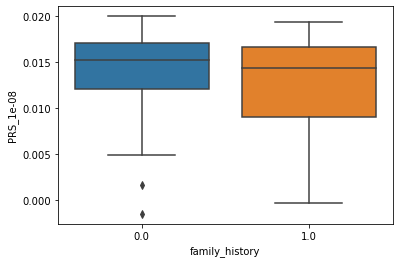

In [144]:
sns.boxplot(x='family_history',
           y='PRS_1e-08',
           data=european_volumetric_dataset_term)

In [145]:
150-86

64

In [7]:
european_volumetric_dataset_term = european_volumetric_dataset_term.merge(
    dHCP_outcomes_CBCL_Bayley,
    left_on='ID',
    right_on='Participant ID',
    how='inner')

mixed_volumetric_dataset_term = mixed_volumetric_dataset_term.merge(
    dHCP_outcomes_CBCL_Bayley,
    left_on='ID',
    right_on='Participant ID',
    how='inner')

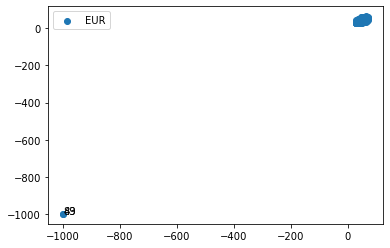

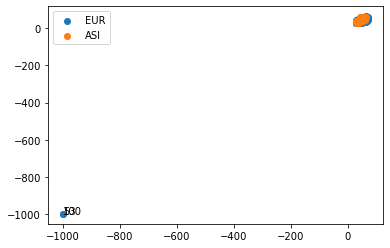

In [8]:
european_volumetric_dataset_term, _ = genetic_file_preprocess.Cohort.remove_outliers(european_volumetric_dataset_term,
                                               ancestry_PCs=['CBCL Externalising t-score','CBCL Internalising t-Score'])

mixed_volumetric_dataset_term, _ = genetic_file_preprocess.Cohort.remove_outliers(mixed_volumetric_dataset_term,
                                               ancestry_PCs=['CBCL Externalising t-score','CBCL Internalising t-Score'])

In [9]:
df = european_volumetric_dataset_term
ancestry_list = [f'euro_Anc_PC{i}' for i in range(1,4)]
cols = [i for i in df.columns if 'score' in i.lower()]
euro_outcome_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = df,
                                                                                                                  thresholds = [i for i in df.columns if 'PRS' in i],
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['Corrected Age - Months','IMD']+ancestry_list,
                                                                                                                  
                                               dependentVar_cols=cols)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 17.47it/s]


In [10]:
euro_outcome_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1).head(100)

,Connection,const_coef,const_pval,Corrected Age - Months_coef,Corrected Age - Months_pval,IMD_coef,IMD_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
249,Aggressive Behaviour Score T score,-0.066367,0.524158,-0.078030,0.304016,-0.132744,0.085233,0.050029,0.523713,0.108121,0.169148,0.037242,0.626254,-0.134683,0.086110,0.139846,0.357567,PRS_1
69,Cognitive Scaled Score,-0.148584,0.156619,-0.038580,0.610126,-0.069568,0.364525,-0.004836,0.950551,0.029708,0.706802,-0.012303,0.870767,-0.130635,0.089776,0.313088,0.041683,PRS_1e-05
217,DSM Anxiety Problems T score,-0.010785,0.917156,-0.069021,0.361268,0.133571,0.082251,0.108128,0.167411,-0.004262,0.956469,-0.137228,0.072725,0.121089,0.121520,0.022725,0.880499,PRS_0.5
196,DSM ADHD Problems T score,0.058037,0.578987,-0.076848,0.312559,-0.125858,0.104152,0.080669,0.307291,0.058902,0.454741,0.034197,0.656661,-0.114058,0.148882,-0.122292,0.422864,PRS_0.1
80,DSM Pervasive Development T score,0.072019,0.490887,0.079457,0.293736,0.000528,0.994492,0.120594,0.122906,-0.091419,0.247400,0.040320,0.593682,0.101973,0.184193,-0.151755,0.320763,PRS_1e-05
16,Somatic Complaints Score T score,-0.041614,0.692364,0.050925,0.503477,-0.043125,0.576857,0.102157,0.194877,0.089001,0.263262,0.025062,0.742140,-0.100701,0.192004,0.087688,0.567693,PRS_1e-08
239,DSM Affective Problems T score,0.000892,0.993174,-0.001204,0.987350,0.054208,0.481236,0.133807,0.089792,0.119461,0.129556,-0.024919,0.744868,-0.096269,0.219642,-0.001880,0.990134,PRS_1
97,Gross Motor Scaled Score,0.129453,0.218495,0.048887,0.520906,-0.050158,0.515297,-0.050711,0.517743,-0.078915,0.319716,0.049453,0.515150,0.080180,0.300132,-0.272777,0.076556,PRS_0.0001
29,Sum Motor Scaled Scores,0.036066,0.731114,0.133248,0.080732,-0.075377,0.328714,-0.044271,0.572508,-0.034227,0.666106,0.035624,0.639228,0.076545,0.320260,-0.075996,0.619679,PRS_1e-07
222,Anxious/Depressed Score T score,-0.058207,0.582478,0.008242,0.914840,0.077790,0.319964,0.051733,0.516626,0.038551,0.628713,-0.018712,0.809653,0.077534,0.330323,0.122651,0.427070,PRS_0.5


In [134]:
df = mixed_volumetric_dataset_term
ancestry_list = [f'mixed_Anc_PC{i}' for i in range(1,6)]
cols = [i for i in df.columns if 'scaled' in i.lower()]
mixed_outcome_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(df = df,
                                                                                                                  thresholds = [i for i in df.columns if 'PRS' in i],
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=['Corrected Age - Months','IMD']+ancestry_list,
                                                                                                                  
                                               dependentVar_cols=['Parenting Style','Parenting Style.1'])
mixed_outcome_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 63.31it/s]


,Connection,const_coef,const_pval,Corrected Age - Months_coef,Corrected Age - Months_pval,IMD_coef,IMD_pval,mixed_Anc_PC1_coef,mixed_Anc_PC1_pval,mixed_Anc_PC2_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
10,Parenting Style,-0.011774,0.896357,-0.227122,0.000733,0.177569,0.007809,0.032564,0.667056,0.147586,...,0.289033,0.093947,0.209468,0.075345,0.282774,-0.060793,0.383035,0.025432,0.849555,PRS_0.001
12,Parenting Style,-0.012493,0.890169,-0.226033,0.000766,0.175675,0.008661,0.025426,0.746987,0.145081,...,0.285223,0.092057,0.219641,0.073785,0.293384,-0.060565,0.409516,0.026986,0.840768,PRS_0.01
18,Parenting Style,-0.007113,0.937205,-0.226801,0.000753,0.175782,0.008641,0.006020,0.947633,0.145978,...,0.277596,0.093486,0.212084,0.070794,0.315442,-0.069592,0.429453,0.015364,0.908520,PRS_0.5
20,Parenting Style,-0.007255,0.935961,-0.226334,0.000769,0.176328,0.008415,0.008642,0.924634,0.146295,...,0.280905,0.093437,0.212474,0.071097,0.313443,-0.065670,0.453459,0.015672,0.906711,PRS_1
16,Parenting Style,-0.008033,0.929121,-0.225590,0.000787,0.175938,0.008610,0.015782,0.854775,0.145227,...,0.279670,0.093796,0.210604,0.072456,0.303225,-0.061025,0.457839,0.017350,0.896778,PRS_0.1
11,Parenting Style.1,0.103203,0.276861,0.017587,0.800375,0.035393,0.610120,0.010581,0.893923,-0.100749,...,0.986702,0.006096,0.937978,-0.037873,0.606225,0.032942,0.651915,-0.222918,0.113894,PRS_0.001
19,Parenting Style.1,0.100687,0.288087,0.017289,0.803803,0.036258,0.602461,0.024003,0.802738,-0.099943,...,0.975393,0.006282,0.936132,-0.035533,0.630449,0.036178,0.695027,-0.217484,0.121855,PRS_0.5
21,Parenting Style.1,0.100754,0.287766,0.017170,0.805056,0.036073,0.604119,0.023624,0.805148,-0.100044,...,0.976537,0.006378,0.935168,-0.035561,0.630183,0.035712,0.697182,-0.217628,0.121604,PRS_1
7,Parenting Style.1,0.102077,0.282533,0.015245,0.826019,0.034734,0.617247,0.003718,0.961807,-0.101137,...,0.991998,0.004898,0.950133,-0.038400,0.601315,0.014112,0.842397,-0.220487,0.118373,PRS_1e-05
17,Parenting Style.1,0.101046,0.286513,0.015560,0.822830,0.035050,0.614775,0.010491,0.907615,-0.100475,...,0.997373,0.005476,0.944323,-0.037415,0.611761,0.016556,0.847568,-0.218260,0.120646,PRS_0.1


In [112]:
df = mixed_volumetric_dataset_term.copy()

In [113]:
prs_model,_ =  data_exploration.MassUnivariate.mass_univariate(df,
                                                          cont_independentVar_cols=ancestry_list,
                                                          dependentVar_cols=['PRS_1e-05'])
cognitive_scale_model, _ = data_exploration.MassUnivariate.mass_univariate(df,
                                                                           cat_independentVar_cols=['Gender'],
                                                          cont_independentVar_cols=ancestry_list+['Corrected Age - Months','IMD'],
                                                          dependentVar_cols=['Cognitive Scaled Score'])

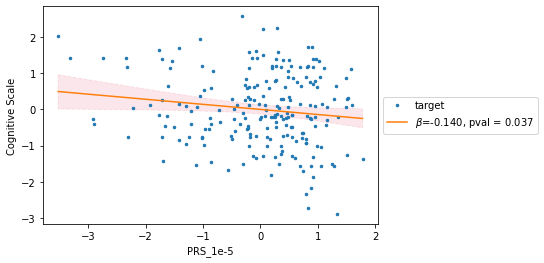

In [114]:
visualisation.plot_Linear_Reg(x=prs_model.resid,
                             y= cognitive_scale_model.resid,
                             xlabel='PRS_1e-5',
                             ylabel='Cognitive Scale',
                             markersize=5)

In [140]:
cols = [i for i in df.columns if 'score' in i.lower()]

pca, X_pca, loadings = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(df = df,
                                                              dependentVar_cols=cols,
                                                                                     n_components=2,scaling=True)

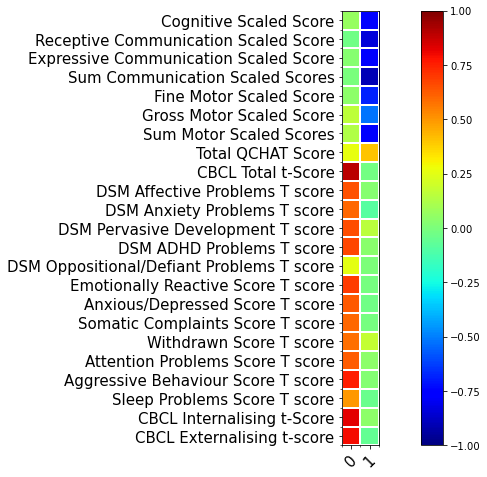

In [116]:
fig,ax = plt.subplots(1,1,figsize=(15,8))
im = ax.imshow(loadings,vmin=-1,vmax=1,cmap='jet')
ax.set_xticks(np.arange(0,len(loadings.columns),1))
ax.set_yticks(np.arange(0,len(loadings.index),1))
ax.set_xticks(np.arange(-.5, len(loadings.columns), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(loadings.index), 1), minor=True)

ax.set_xticklabels(loadings.columns,rotation=45,fontsize=15)
ax.set_yticklabels(loadings.index,rotation=0,fontsize=15)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

fig.colorbar(im, orientation='vertical')

In [141]:
df = mixed_volumetric_dataset_term
ancestry_list = [f'mixed_Anc_PC{i}' for i in range(1, 6)]
mixed_outcome_mass_univariate_pca = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df=df,
    thresholds=[i for i in df.columns if 'PRS' in i],
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['Corrected Age - Months', 'IMD','GA_vol'] + ancestry_list,
    dependentVar_cols=X_pca)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 61.86it/s]


In [139]:
data_exploration.MassUnivariate.mass_univariate(df,
                                               cat_independentVar_cols=['Gender'],
                                               cont_independentVar_cols=X_pca,
                                               dependentVar_cols=['GA_vol'])

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f6a73b2edf0>,
         const_coef  const_pval  Cont_0_coef  Cont_0_pval  Cont_1_coef  \
 GA_vol   -0.050266    0.585835    -0.023011     0.732745    -0.185582   
 
         Cont_1_pval  Gender_2.0_coef  Gender_2.0_pval  
 GA_vol     0.006673         0.108575         0.425155  )

In [142]:
mixed_outcome_mass_univariate_pca.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Corrected Age - Months_coef,Corrected Age - Months_pval,IMD_coef,IMD_pval,GA_vol_coef,GA_vol_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC3_pval,mixed_Anc_PC4_coef,mixed_Anc_PC4_pval,mixed_Anc_PC5_coef,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
11,Dependent_Var_1,0.076851,0.398792,-0.030280,0.650791,0.098763,0.138822,-0.179327,0.008909,-0.178045,...,0.107509,0.011725,0.876342,0.004089,0.953819,0.076076,0.278197,-0.165997,0.220314,PRS_0.001
15,Dependent_Var_1,0.073967,0.416285,-0.031083,0.641976,0.101667,0.128875,-0.179552,0.008849,-0.155621,...,0.101586,0.013901,0.853893,0.008482,0.904704,0.083770,0.294184,-0.159769,0.237092,PRS_0.05
17,Dependent_Var_1,0.072237,0.427387,-0.032040,0.631809,0.100915,0.131878,-0.178523,0.009249,-0.156409,...,0.102352,0.011902,0.874631,0.007734,0.913102,0.077689,0.347737,-0.156031,0.248208,PRS_0.1
21,Dependent_Var_1,0.071355,0.433044,-0.031054,0.642825,0.100383,0.133635,-0.177086,0.009790,-0.148074,...,0.103722,0.012197,0.871576,0.009283,0.896014,0.082684,0.348178,-0.154126,0.254010,PRS_1
19,Dependent_Var_1,0.071236,0.433909,-0.031156,0.641932,0.100492,0.133499,-0.177009,0.009836,-0.150182,...,0.104802,0.011770,0.876040,0.008948,0.899763,0.079023,0.372619,-0.153869,0.254907,PRS_0.5
7,Dependent_Var_1,0.075979,0.404980,-0.034373,0.606726,0.098603,0.140356,-0.179354,0.009034,-0.190262,...,0.116657,0.009150,0.903413,0.003060,0.965477,0.053625,0.432109,-0.164116,0.226597,PRS_1e-05
13,Dependent_Var_1,0.076170,0.403983,-0.033200,0.619710,0.099592,0.137119,-0.179216,0.009089,-0.176945,...,0.112258,0.012686,0.866745,0.005145,0.942064,0.056303,0.446833,-0.164527,0.225761,PRS_0.01
1,Dependent_Var_1,0.073899,0.417486,-0.035349,0.596337,0.099049,0.139082,-0.179589,0.008994,-0.194328,...,0.120261,0.009067,0.904304,0.002604,0.970624,0.048974,0.468016,-0.159621,0.238432,PRS_1e-08
9,Dependent_Var_1,0.075463,0.408244,-0.033403,0.617677,0.099185,0.138699,-0.179273,0.009095,-0.188568,...,0.114995,0.010203,0.892438,0.003437,0.961239,0.049456,0.475622,-0.163001,0.229767,PRS_0.0001
5,Dependent_Var_1,0.074477,0.414269,-0.035397,0.596044,0.097849,0.143552,-0.178901,0.009249,-0.193057,...,0.121702,0.009137,0.903593,0.001972,0.977752,0.043001,0.526065,-0.160870,0.235505,PRS_1e-06


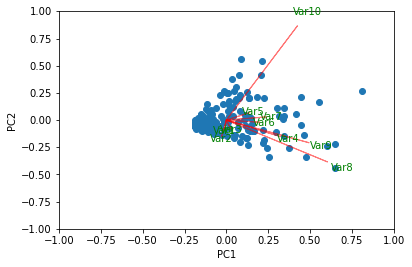

In [137]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
myplot(CBCL_Bayley_PCA[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

In [149]:
abs(pca.explained_variance_ratio_)

array([0.37275812, 0.17335888, 0.14513648, 0.10322412, 0.0594611 ,
       0.04594735, 0.03747391, 0.03270018, 0.01858531, 0.01135455])

In [150]:
european_volumetric_dataset_term['PC1'] = CBCL_Bayley_PCA[:,0]
european_volumetric_dataset_term['PC2'] = CBCL_Bayley_PCA[:,1]
european_volumetric_dataset_term['PC3'] = CBCL_Bayley_PCA[:,2]

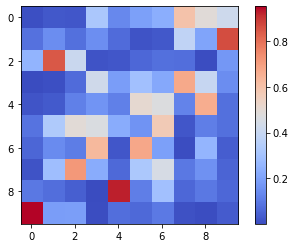

In [148]:
plt.imshow(abs(pca.components_),cmap='coolwarm')
plt.colorbar()

In [107]:
list(zip(dHCP_outcomes.columns,range(len(dHCP_outcomes.columns))))

[('Participant ID', 0),
 ('Event Name', 1),
 ('Repeat Instrument', 2),
 ('Repeat Instance', 3),
 ('IMD Score', 4),
 ('IMD Quintile', 5),
 ("Child's Sex", 6),
 ('Bayley First or Second?', 7),
 ('Eye Tracking First or Second', 8),
 ('Age - Months', 9),
 ('Age - Days', 10),
 ('Corrected Age - Months', 11),
 ('Corrected Age - Days', 12),
 ('Cognitive Scaled Score', 13),
 ('Composite Score', 14),
 ('Cognitive Rank', 15),
 ('Receptive Communication Scaled Score', 16),
 ('Expressive Communication Scaled Score', 17),
 ('Sum Communication Scaled Scores', 18),
 ('Communication Composite Score', 19),
 ('Communication Rank', 20),
 ('Fine Motor Scaled Score', 21),
 ('Gross Motor Scaled Score', 22),
 ('Sum Motor Scaled Scores', 23),
 ('Motor Composite Score', 24),
 ('Motor Rank', 25),
 ('Cognition', 26),
 ('Receptive Communication', 27),
 ('Expressive Communication', 28),
 ('Fine Motor', 29),
 ('Gross Motor', 30),
 ('Laxness', 31),
 ('Over-reactivity', 32),
 ('Verbosity', 33),
 ('Parenting Style', 3

In [151]:
def calculate_mass_univariate_across_multiple_PRS_thresholds(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['Corrected Age - Months'],
    dependentVar_cols=[i for i in dHCP_outcomes_CBCL.columns if 'T score' in i],
    thresholds=[
        i for i in european_volumetric_dataset_term.columns if 'PRS' in i
    ]):
    """
    Perform mass univariate tests to a range of PRS_threshold
    Args:
        see mass_univariate.
        threshold = list of PRS thresholds
    Return:
        new_df (Data Frame)
    """
    new_df = pd.DataFrame()

    for threshold in tqdm.tqdm(thresholds):
        _, temp_model_summary = data_exploration.MassUnivariate.mass_univariate(
            df,
            cat_independentVar_cols=cat_independentVar_cols,
            cont_independentVar_cols=cont_independentVar_cols + [threshold],
            dependentVar_cols=dependentVar_cols)
        

        temp_model_summary.reset_index(drop=False, inplace=True)
        temp_model_summary.rename(
            {
                'index': 'Connection',
                threshold + '_coef': 'PRS_coef',
                threshold + '_pval': 'PRS_pval'
            },
            axis=1,
            inplace=True)
        temp_model_summary['threshold'] = threshold
        new_df = new_df.append(temp_model_summary)

    new_df.reset_index(drop=True, inplace=True)
    return new_df

In [156]:
df = european_volumetric_dataset_term
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
european_volumetric_term_mass_univariate = calculate_mass_univariate_across_multiple_PRS_thresholds(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['Corrected Age - Months']+ancestry,
    dependentVar_cols=['PC1','PC2','PC3'],
    thresholds=[i for i in df.columns if 'PRS' in i])
# i for i in df.columns if 'PRS' in i

# df = mixed_volumetric_dataset_term_with_bayley_score
# ancestry = ['mixed_Anc_PC'+str(i) for i in range(1,6)]
# mixed_volumetric_term_mass_univariate = calculate_mass_univariate_across_multiple_PRS_thresholds(
#     df,
#     cat_independentVar_cols=['Gender','assessor'],
#     cont_independentVar_cols=['corr_age_at_assess_m','age_at_assess_m','imdscaore']+ancestry,
#     dependentVar_cols=['cog_scaled',
#               'rec_scaled','exp_scaled',
#               'language_sum_scaled',
#               'fm_scaled','gm_scaled',
#                'motor_sum_scaled'],
#     thresholds=[i for i in df.columns if 'PRS' in i])

100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.94it/s]


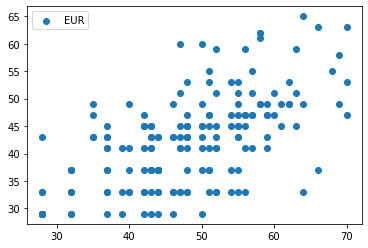

In [157]:
european_volumetric_dataset_term, _ = genetic_file_preprocess.Cohort.remove_outliers(european_volumetric_dataset_term,
                                               ancestry_PCs=['CBCL Externalising t-score','CBCL Internalising t-Score'])

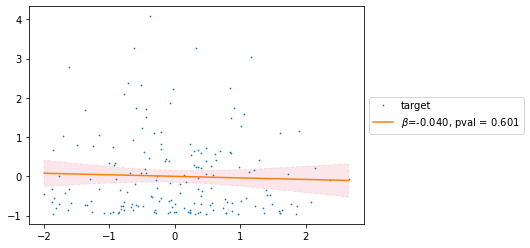

In [173]:
visualisation.plot_Linear_Reg(european_volumetric_dataset_term['Imperial 17']+european_volumetric_dataset_term['Imperial 18'],
                             european_volumetric_dataset_term['PC1'])

In [158]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,Corrected Age - Months_coef,Corrected Age - Months_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
30,PC1,0.032431,0.758859,-0.022625,0.768766,0.070117,0.378625,0.037050,0.639157,0.026300,0.733918,-0.064227,0.415030,-0.068337,0.656960,PRS_1
27,PC1,0.032420,0.759021,-0.022207,0.773110,0.070861,0.373949,0.037248,0.637489,0.025313,0.743578,-0.058272,0.460069,-0.068314,0.657187,PRS_0.5
24,PC1,0.031736,0.764075,-0.020583,0.788975,0.071179,0.372927,0.037332,0.636853,0.025025,0.747002,-0.051918,0.511618,-0.066872,0.664203,PRS_0.1
21,PC1,0.030498,0.773186,-0.020214,0.792647,0.073090,0.358191,0.039102,0.621350,0.023753,0.758831,-0.049105,0.532822,-0.064264,0.676986,PRS_0.05
17,PC3,0.161279,0.123162,-0.015828,0.834424,-0.047060,0.546080,-0.088694,0.255887,0.067803,0.369816,0.043104,0.574674,-0.339838,0.026593,PRS_0.001
16,PC2,0.010918,0.918019,-0.028439,0.712068,-0.042110,0.595450,-0.069115,0.383837,-0.014784,0.847422,-0.042395,0.587470,-0.023005,0.881865,PRS_0.001
19,PC2,0.010676,0.919986,-0.027030,0.725435,-0.042066,0.597075,-0.070157,0.376519,-0.014757,0.848038,-0.033763,0.667583,-0.022496,0.884895,PRS_0.01
15,PC1,0.030635,0.772609,-0.018651,0.808601,0.076452,0.335222,0.038564,0.626553,0.018936,0.805222,-0.030673,0.694442,-0.064551,0.676571,PRS_0.001
13,PC2,0.012353,0.907329,-0.026509,0.730672,-0.039847,0.614827,-0.069429,0.382557,-0.017423,0.820224,-0.026411,0.734274,-0.026029,0.866518,PRS_0.0001
6,PC1,0.035100,0.740469,-0.014087,0.854282,0.081662,0.302323,0.034655,0.662707,0.016498,0.829392,0.024759,0.749302,-0.073960,0.632309,PRS_1e-06


In [114]:
mixed_volumetric_term_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1).head(25)

,Connection,const_coef,const_pval,corr_age_at_assess_m_coef,corr_age_at_assess_m_pval,age_at_assess_m_coef,age_at_assess_m_pval,imdscaore_coef,imdscaore_pval,mixed_Anc_PC1_coef,...,mixed_Anc_PC5_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,assessor_2.0_coef,assessor_2.0_pval,assessor_3.0_coef,assessor_3.0_pval,threshold
21,cog_scaled,-0.067427,0.558008,0.295083,0.048143,-0.390924,0.009366,-0.061680,0.362024,0.204098,...,0.758051,-0.151073,0.027565,0.211737,0.123402,-0.088146,5.331601e-01,0.134424,0.688954,PRS_1e-05
36,rec_scaled,-0.111917,0.340437,0.266042,0.080309,-0.340153,0.025954,-0.034768,0.613548,0.123194,...,0.849736,-0.101883,0.154686,0.191937,0.170045,0.072681,6.140346e-01,-0.174558,0.609857,PRS_0.001
23,exp_scaled,0.202079,0.069812,0.157345,0.273142,-0.175444,0.223726,-0.064850,0.320627,0.110884,...,0.618428,0.045398,0.490158,0.215650,0.103978,-0.704460,5.578815e-07,-0.090613,0.779707,PRS_1e-05
38,language_sum_scaled,0.035225,0.761216,0.244484,0.103747,-0.299158,0.047243,-0.055158,0.417812,0.132044,...,0.898154,-0.047491,0.501253,0.229329,0.097541,-0.318838,2.605438e-02,-0.149202,0.658973,PRS_0.001
33,gm_scaled,0.114636,0.338201,0.191192,0.216475,-0.154067,0.320404,-0.022540,0.748580,0.069765,...,0.763040,0.048187,0.503537,-0.264664,0.064217,0.085292,5.615103e-01,-0.594201,0.090403,PRS_0.0001
55,motor_sum_scaled,0.146095,0.216265,0.347582,0.023432,-0.304879,0.047155,-0.043713,0.529559,0.158170,...,0.869906,-0.039126,0.633486,-0.113512,0.418130,-0.213921,1.415243e-01,-0.059248,0.863477,PRS_0.05
25,fm_scaled,0.122520,0.280888,0.355944,0.015889,-0.317244,0.032028,-0.038638,0.562328,0.208735,...,0.991125,-0.028798,0.668350,0.070937,0.599741,-0.416130,3.150917e-03,0.443226,0.181662,PRS_1e-05


In [ ]:
visualisation.plot()

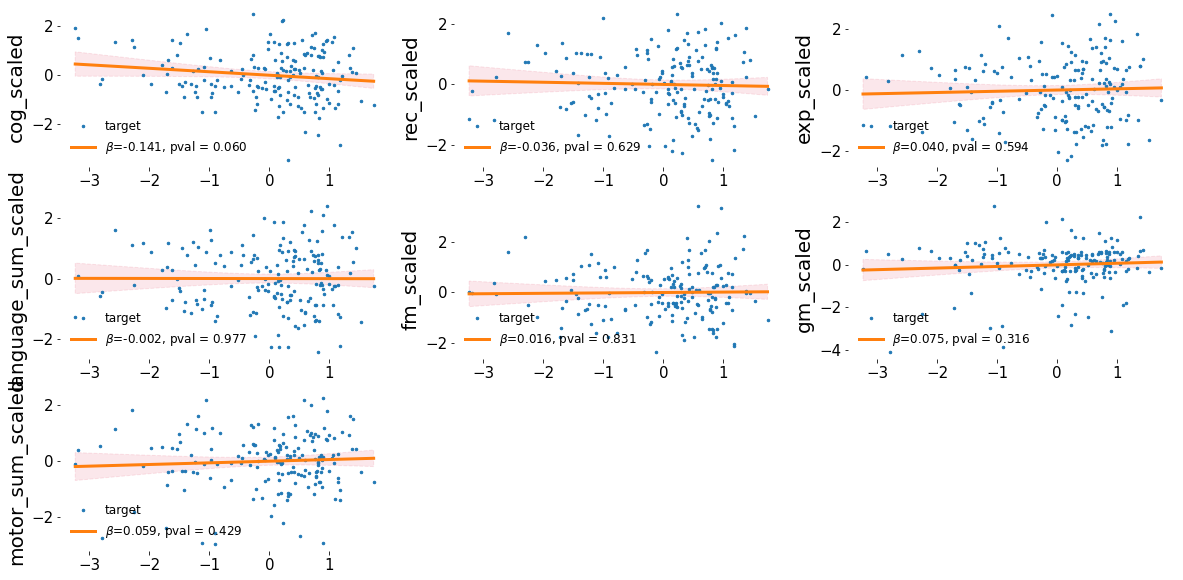

In [123]:
dependent_variables = ['cog_scaled',
              'rec_scaled','exp_scaled',
              'language_sum_scaled',
              'fm_scaled','gm_scaled',
               'motor_sum_scaled']
fig,axes = plt.subplots(3,3,figsize=(20,10))
axes = axes.flatten()
axes[-1].remove()
axes[-2].remove()

df = european_volumetric_dataset_term_with_bayley_score
ancestry_list = ['euro_Anc_PC'+str(i) for i in range(1,4)]
threshold = 'PRS_1e-05'
for ax,dependent_variable,ylabel in zip(axes,dependent_variables,dependent_variables):
    model, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                              cat_independentVar_cols=['Gender','assessor'],
                                                              cont_independentVar_cols=[
                                                                  'corr_age_at_assess_m','age_at_assess_m','imdscaore'
                                                              ]+ancestry_list,
                                                              dependentVar_cols=[dependent_variable])
    visualisation.plot_Linear_Reg(x = df[[threshold]].values,
                                 y = model.resid.values,
                                 data = df,
                                 ylabel = ylabel,
                                 xlabel = f'{threshold}',
                                 axes=ax,legend_loc='inside',linewidth = 3,markersize=5)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(None,fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='lower left',fontsize=12,frameon=False)
    sns.despine(bottom=True,left=True,right=True)

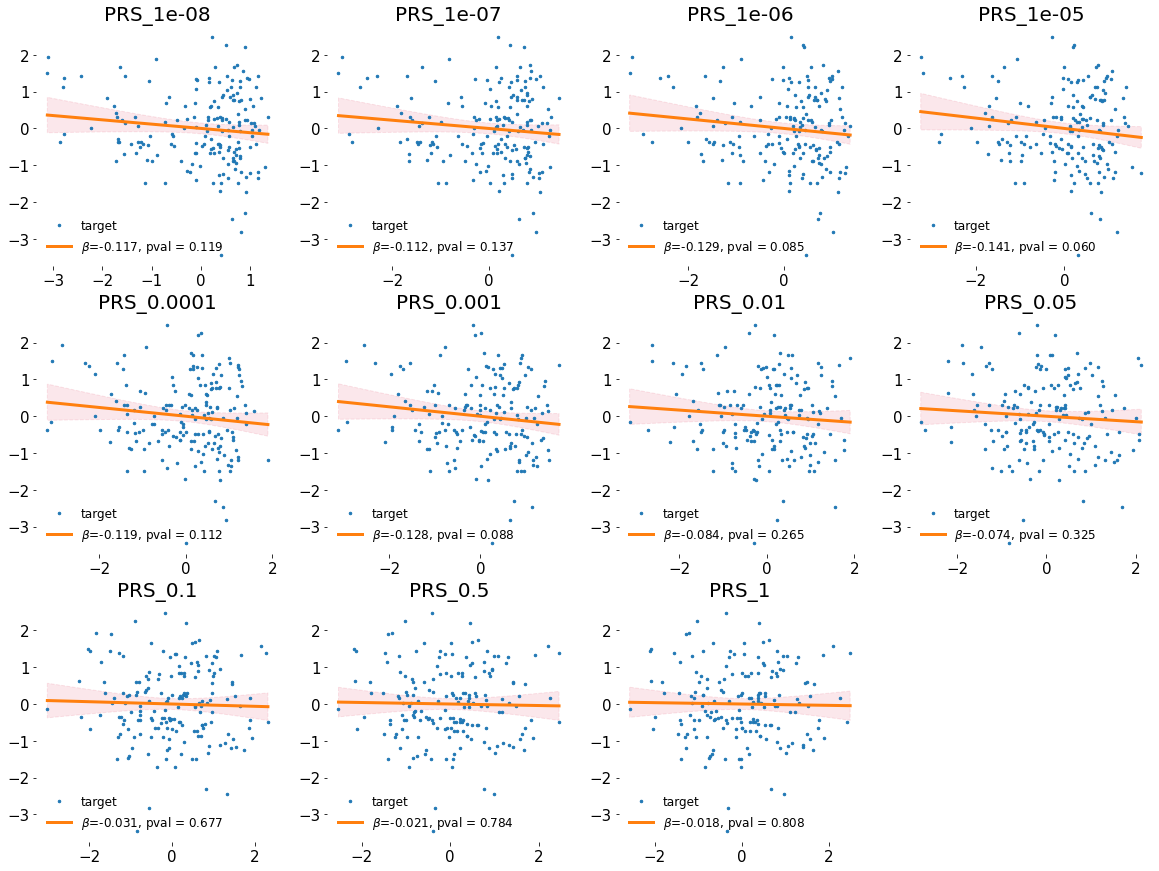

In [135]:
dependent_variables = ['cog_scaled',
              'rec_scaled','exp_scaled',
              'language_sum_scaled',
              'fm_scaled','gm_scaled',
               'motor_sum_scaled']
fig,axes = plt.subplots(3,4,figsize=(20,15))
axes = axes.flatten()
axes[-1].remove()

# df = mixed_volumetric_dataset_term_with_bayley_score
# ancestry_list = ['mixed_Anc_PC'+str(i) for i in range(1,6)]

df = european_volumetric_dataset_term_with_bayley_score
ancestry_list = ['euro_Anc_PC'+str(i) for i in range(1,4)]

thresholds = [i for i in df.columns if 'PRS' in i]
for ax,threshold in zip(axes,thresholds):
    model, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                              cat_independentVar_cols=['Gender','assessor'],
                                                              cont_independentVar_cols=[
                                                                  'corr_age_at_assess_m','age_at_assess_m','imdscaore'
                                                              ]+ancestry_list,
                                                              dependentVar_cols=['cog_scaled'])
    visualisation.plot_Linear_Reg(x = df[[threshold]].values,
                                 y = model.resid.values,
                                 data = df,
                                 ylabel = 'cog_scaled',
                                 xlabel = f'{threshold}',
                                 axes=ax,legend_loc='inside',linewidth = 3,markersize=5)
    ax.set_xlabel(None,fontsize=20)
    ax.set_ylabel(None,fontsize=20)
    ax.set_title(f'{threshold}',fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='lower left',fontsize=12,frameon=False)
    sns.despine(bottom=True,left=True,right=True)

fig.savefig('cognitive_score_neonates_euro.png',dpi=300)

In [ ]:
[0 if ]